In [12]:
import numpy as np
import math
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve, least_squares, minimize
from scipy.stats import qmc 
from scipy.linalg import norm
import random
import matplotlib.animation
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import argrelmin, argrelmax
import matplotlib.pyplot as plt
from numba import jit

In [13]:
@jit
def model(t, X, V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω):
    
    N_n = X[0]
    N_r = X[1]
    P_U = X[2] #Susceptible Hosts
    P_I = X[3] #Infected Hosts
    Z   = X[4] #Zooplankton
    V_I = X[5] #Internal viruses from host nucleotide recycling 
               #and de novo nucleotide synthesis
    V_E = X[6] #Free (extracellular) viruses 
    
    alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
    beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3
    
    if V_I == 0:  ν_i = 0 #avoid divison by 0 when evaluating ν_i
        
    else:
        ν_i = V_I / ((beta / alpha) * P_I + V_I)
        
    P = P_U + P_I
    
    N = N_n + N_r
    
    nutr_lim = N / (K_N + N)
     
    if N == 0: N = 1 #avoid divison by 0 when evaluating nutrient ratios

    light_lim = np.log((K_I + I_0 / K_I)) / K_h  #light limitation term
    
    
    #Defining scaling factors depending on values of state variables
    thresh = 1e-8
    
    P_U_scale = 1
    if P_U < thresh:
        P_U_scale = P_U / thresh 
       
    P_I_scale = 1
    if P_I < thresh:
        P_I_scale = P_I / thresh

    Z_scale = 1 
    if Z < thresh:
        Z_scale = Z / thresh

    V_I_scale = 1
    if V_I < thresh:
        V_I_scale = V_I / thresh  
    
    V_E_scale = 1
    if V_E < thresh:
        V_E_scale = V_E / thresh   
        
        
    #Phytoplankton uninfected
    P_U_growth = P_U_scale * (P_U + P_I_scale * μ_u * P_I) * V_max * nutr_lim * light_lim
    
    P_U_grazing   = P_U * g * Z_scale * Z / K_P
    P_U_mortality = P_U * λ_P
    P_U_adsorp    = P_I_scale * P_U * (1 - ν_x) * φ * μ_s * V_E
    P_U_entrain   = P_U * ω
    
    P_U_dt = P_U_growth - P_U_grazing - P_U_mortality - P_U_adsorp - P_U_entrain
    
    
    #Phytoplankton infected
    P_I_adsorp       = P_I_scale * (1 - ν_x) * φ * μ_s * P_U * V_E
    P_I_growth       = P_I_scale * (1 - P_U_scale * μ_u) * P_I * V_max * nutr_lim * light_lim
    
    P_I_grazing      = P_I * g * Z_scale * Z / K_P
    P_I_mortality    = P_I * λ_P
    P_I_nt_recycling = V_I_scale * P_I * ν_i * μ_V
    P_I_lysis        = P_I * ν_i * δ
    P_I_entrain      = P_I * ω
    
    P_I_dt = P_I_adsorp + P_I_growth - P_I_grazing - P_I_mortality \
             - P_I_nt_recycling - P_I_lysis - P_I_entrain
    
    
    #Zooplankton
    Z_assimilation = Z_scale * Z * γ_Z * g * (P + V_I) / K_P
    Z_mortality    = Z * (λ_Z + λ_Z_hat * Z)
    Z_entrain      = Z * ω

    Z_dt = Z_assimilation - Z_mortality - Z_entrain
    
    
    #Intracellular viruses
    V_I_growth  = V_I_scale * ν_i * (beta / alpha) * (μ_V + (nutr_lim * μ_V_prime)) * P_I
    V_I_adsorp  = V_I_scale * ν_x * (beta / alpha) * φ * μ_s * P_U * V_E
    
    V_I_lysis   = V_E_scale * V_I * ν_i * δ
    V_I_grazing = V_I * g * Z_scale * Z / K_P
    V_I_h_mort  = V_E_scale * V_I * λ_P
    V_I_entrain = V_I * ω
    
    V_I_dt = V_I_adsorp + V_I_growth - V_I_lysis - V_I_grazing - V_I_h_mort - V_I_entrain
    
    
    #Extracellular
    V_E_h_mort = V_E_scale * V_I * μ_r * λ_P

    V_E_mortality = λ_E * V_E
    V_E_adsorp    = V_I_scale * ν_x * (beta / alpha) * φ * μ_s * P_U * V_E
    V_E_entrain   = V_E * ω
    
    V_E_dt = - V_E_adsorp + V_I_lysis + V_E_h_mort - V_E_mortality - V_E_entrain
    
    
    #Nitrate
    N_n_accum     = (N_n / N) * (P_U_growth + P_I_growth)
    N_n_intracell = V_I_scale * (N_n / N) * ν_i * P_I * (beta / alpha) * (nutr_lim * μ_V_prime)
    N_n_entrain   = ω * N_n 
    
    N_n_dt = - N_n_accum - N_n_intracell - N_n_entrain
            
        
    #Recycled nutrients
    N_r_accum        = (N_r / N) * (P_U_growth + P_I_growth)
    
    nt_recycling     = ν_i * P_I * (1 - (beta / alpha)) * μ_V
    denovo_syn       = ν_i * P_I * (N_r / N) * (beta / alpha) * (nutr_lim * μ_V_prime)
    N_r_intracell    = V_I_scale * nt_recycling - denovo_syn
    
    N_r_mortality    = λ_P * (P + V_E_scale * (1 - μ_r) * V_I)
    N_r_Ve_mort      = λ_E * V_E
    N_r_lysis        = ν_i * δ * P_I
    N_r_sloppy_munch = (1 - γ_Z) * g * Z_scale * Z * (P + V_I) / K_P
    N_r_entrain      = N_r * ω
    
    N_r_remin  = (μ_P * N_r_mortality) + N_r_Ve_mort + (μ_delta * N_r_lysis) \
             + (μ_g * N_r_sloppy_munch) + (μ_Z * Z_mortality) - N_r_entrain

    N_r_export = (1 - μ_P) * N_r_mortality + (1 - μ_delta) * N_r_lysis \
             + (1 - μ_g) * N_r_sloppy_munch + (1 - μ_Z) * Z_mortality
    
    N_r_dt = - N_r_accum + N_r_intracell + N_r_remin + N_r_export
            
    
    return N_n_dt, N_r_dt, P_U_dt, P_I_dt, Z_dt, V_I_dt, V_E_dt

In [14]:
#Inital Conditions / parameter values

alpha = (1 / 1.42e8) * 2.1e-10 * 1e6  # Host conversion, mmol ml / NT m^3
beta  = (1 / 4e5) * 1.27e-15 * 1e6    # Viral conversion, mmol ml / NT m^3

Nn_0 = 0    #mmol m^-3
Nr_0 = 0    #mmol m^-3  #should keep Nr_0 above 1, for perturbation tests
Pu_0 = .6   #mmol m^-3 
Pi_0 = 1e-7 #mmol m^-3
Z_0  = 2    #mmol m^-3
Vi_0 = 1e-7 #mmol m^-3

Ve_0 = .0003

z0 = [Nn_0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]

V_max     = 1.4              # Host growth rate
γ_Z       = .4               # Growth rate / Assimilation frequency 
φ         = 3.5e-10 / beta   # Viral adsorption rate, m^3 / (mmol * day)
g         = 1.4              # d^-1 Maximum specific grazing rate

V_ind     = 4e5        # NT per individual virus, Table S1
S_ind     = 1.42e8     # NT per individual host, Table S1

ν_x       = V_ind / (V_ind + S_ind) 
                       # Proportion of nutrients originating 
                       # from virus in host-virus pair

λ_P       = .05        # Mortality & Respiration rate
λ_Z       = .12        # d^-1, Linear mortality & respiration & egestion
λ_Z_hat   = 0         # Quadratic mortality & respiration & egestion
λ_E       = .1         # ARBITRARILY CHOSEN VALUE: Extracellular virus mortality 
δ         = .45        # Host lysis rate

μ_V       = .5         # Max host NT recycling rate 
μ_V_prime = 1.6        # Max de novo NT synthesis rate
μ_u       = 0
μ_r       = 0          # Viral assimilation fraction related to host mortality
μ_s       = 1
μ_P       = .4         # Remineralization fraction due to mortality
μ_delta   = .4         # ARBITRARILY CHOSEN VALUE: Remineralization fraction due to lysis
μ_g       = .4         # Remineralization fraction due to sloppy-eating
μ_Z       = .4         # Remineralization fraction due to grazer mortality

K_N       = .1         # mmol m^-3 # Half-saturation constant for nutrient limitation
K_I       = 1          # Half-saturation for light limitation
K_h       = 1          # Half-saturation for ... ?
K_P       = 2.8        # mmol m^-3, Half-saturation constant for grazing of P
I_0       = (np.e - 1) # Compensation irradiance

ω         = 0 # Entraintment term

param_labels = ['V_max', 'γ_Z', 'φ', 'g', 'ν_x', 'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 
                'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 'μ_P', 'μ_delta', 
                'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0', 'ω']

param = [V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω]

**Plotting Systems Responce to inclusion of quadratic zooplankton mortality\:**

In [15]:
#Linear Z mortality simulations 
num = 50
t = 100

varied_values = np.linspace(0, 20, num) #Start at > 0 if running perturbations

linear_sols = []

for i, val in enumerate(varied_values):
    #Redifines initial state conditions
    #**SET STATE VAR INDEX**
    z0[1] = val #Nr_0 == z0[1]
    
    solution = solve_ivp(model, [0, t], z0, args=param, min_step = 1e-8, max_step = .1, method = 'LSODA')       
    linear_sols.append(solution)

In [16]:
#Animation of progression of solutions
%matplotlib tk

time = [solution.t for solution in linear_sols]

Nn = [solution.y[0] for solution in linear_sols]
Nr = [solution.y[1] for solution in linear_sols]
PU = [solution.y[2] for solution in linear_sols]
PI = [solution.y[3] for solution in linear_sols]
Z  = [solution.y[4] for solution in linear_sols]        
VI = [solution.y[5] for solution in linear_sols]
VE = [solution.y[6] for solution in linear_sols]

fig, ax = plt.subplots(figsize=(15, 4))

ax.set_xlim(0, t)
ax.set_ylim(0, 10)

def animate(i):
    ax.clear()
    
    ax.plot(time[i], Nn[i], color="darkviolet"      ,label = "N_n")
    ax.plot(time[i], Nr[i], color="blue"            ,label = "N_r")
    ax.plot(time[i], PU[i], color="mediumaquamarine",label = "P_U")
    ax.plot(time[i], PI[i], color="limegreen"       ,label = "P_I")
    ax.plot(time[i], Z [i], color="darkgreen"       ,label = "Z ")
    ax.plot(time[i], VI[i], color="red"             ,label = "V_I")
    ax.plot(time[i], VE[i], color="darkred"         ,label = "V_E")

    ax.legend(loc=(1.01, 0))
    ax.set_xlabel('Time (Day)')
    ax.set_ylabel('mmol N / m^3')
    ax.set_title(f'Dynmaics for λ_Z = {λ_Z}, λ_Z_hat = {λ_Z_hat}, and N_r = {round(varied_values[i], 5)}',fontsize = 16)
    ax.set_yscale('log')
    ax.set_ylim(1e-9, 1e2)
    ax.grid(alpha=.3)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(linear_sols))
plt.show()

In [17]:
#Quad Z mortality simulations
λ_Z       = .05
λ_Z_hat   = .1

param[6]   = .05  #linear mortality rate
param[7]   = .1   #Quad mortality coef

quad_sols = []

for i, val in enumerate(varied_values):
    #Redifines initial state conditions
    #SET STATE VAR INDEX
    z0[1] = val
    
    solution = solve_ivp(model, [0, t], z0, args=param, min_step = 1e-8, max_step = .1, method = 'LSODA')       
    quad_sols.append(solution)

In [21]:
#Animation of progression of solutions
%matplotlib tk

time = [solution.t for solution in linear_sols]

Nn = [solution.y[0] for solution in linear_sols]
Nr = [solution.y[1] for solution in linear_sols]
PU = [solution.y[2] for solution in linear_sols]
PI = [solution.y[3] for solution in linear_sols]
Z  = [solution.y[4] for solution in linear_sols]        
VI = [solution.y[5] for solution in linear_sols]
VE = [solution.y[6] for solution in linear_sols]

fig, ax = plt.subplots(figsize=(15, 4))

ax.set_xlim(0, t)
ax.set_ylim(0, 10)

def animate(i):
    ax.clear()
    
    ax.plot(time[i], Nn[i], color="darkviolet"      ,label = "N_n")
    ax.plot(time[i], Nr[i], color="blue"            ,label = "N_r")
    ax.plot(time[i], PU[i], color="mediumaquamarine",label = "P_U")
    ax.plot(time[i], PI[i], color="limegreen"           ,label = "P_I")
    ax.plot(time[i], Z [i], color="darkgreen"       ,label = "Z ")
    ax.plot(time[i], VI[i], color="red"             ,label = "V_I")
    ax.plot(time[i], VE[i], color="darkred"         ,label = "V_E")

    ax.legend(loc=(1.01, 0))
    ax.set_xlabel('Time (Day)')
    ax.set_ylabel('mmol N / m^3')
    ax.set_title(f'Dynmaics for λ_Z = {λ_Z}, λ_Z_hat = {λ_Z_hat}, and N_r = {round(varied_values[i], 5)}',fontsize = 16)
    ax.set_yscale('log')
    ax.set_ylim(1e-9, 1e2)
    ax.grid(alpha=.3)
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(linear_sols))
plt.show()

**Testing the hypothesis that there is a 1-to-1 mapping between the late-time/steady state and the total N of the system, for a given set of parameters. Thus, the steady state/late time characteristics of the system can be fully described by varying total N and the parameters.**

In [22]:
#Generating semi-random initial state values which sum to specified total n

def func(total_N, num_sim, t_span):

    sols = []
    
    init_cond = np.random.random((6, num_sim))  # create random numbers
    init_cond = init_cond / np.sum(init_cond, axis=0) * total_N   # force them to sum to totals
    init_cond = np.transpose(init_cond)
    init_cond = np.insert(init_cond, 0, 0, axis=1)
    
    for initial in init_cond:
        z0 = initial
    
        solution = solve_ivp(model, [0, t_span], z0, args=param, min_step = 1e-8, max_step = .1, method = 'LSODA')       
        sols.append(solution)
        
    return init_cond, sols

In [23]:
total_N, num_sim, t_span = 10, 25, 1000

init_cond, sols = func(total_N, num_sim, t_span)

In [24]:
#Calculating steady-state / central-tendancy of oscillatory solutions

#Define dictionary to hold steady state values for each simulation
keys = "N_n", "N_r", "P_U", "P_I", "Z", "V_I", "V_E", "N_T"

brute_force = {"N_n": np.array([]), "N_r": np.array([]), 
               "P_U": np.array([]), "P_I": np.array([]), 
               "Z": np.array([]), "V_I": np.array([]), 
               "V_E": np.array([]), "N_T": np.array([])}

for i, solution in enumerate(sols):

    total = 0
    index = int(len(solution.t) * .9) #Take last 10% of solution

    for k, key in enumerate(keys[:-1]):

        y_end = solution.y[k][index: ] #look at tail end of specific state

        l_min = argrelmin(y_end)[0]  #Extracting local minimum and maximum
        l_max = argrelmax(y_end)[0]

        if (len(l_min) == 0) or (len(l_max) == 0):
            avg = solution.y[k][-1]

        else:
            y_min = y_end[l_min]
            y_max = y_end[l_max]

            min_n_max = np.concatenate((y_min, y_max))
            avg = np.mean(min_n_max)

        brute_force[key] = np.append(brute_force[key], avg)
        total += avg


    brute_force["N_T"] = np.append(brute_force["N_T"], total)
    
N_T = brute_force['N_T']
N_n = brute_force['N_n']
N_r = brute_force['N_r']
P_U = brute_force['P_U']
P_I = brute_force['P_I']
Z   = brute_force['Z']
V_I = brute_force['V_I']
V_E = brute_force['V_E']

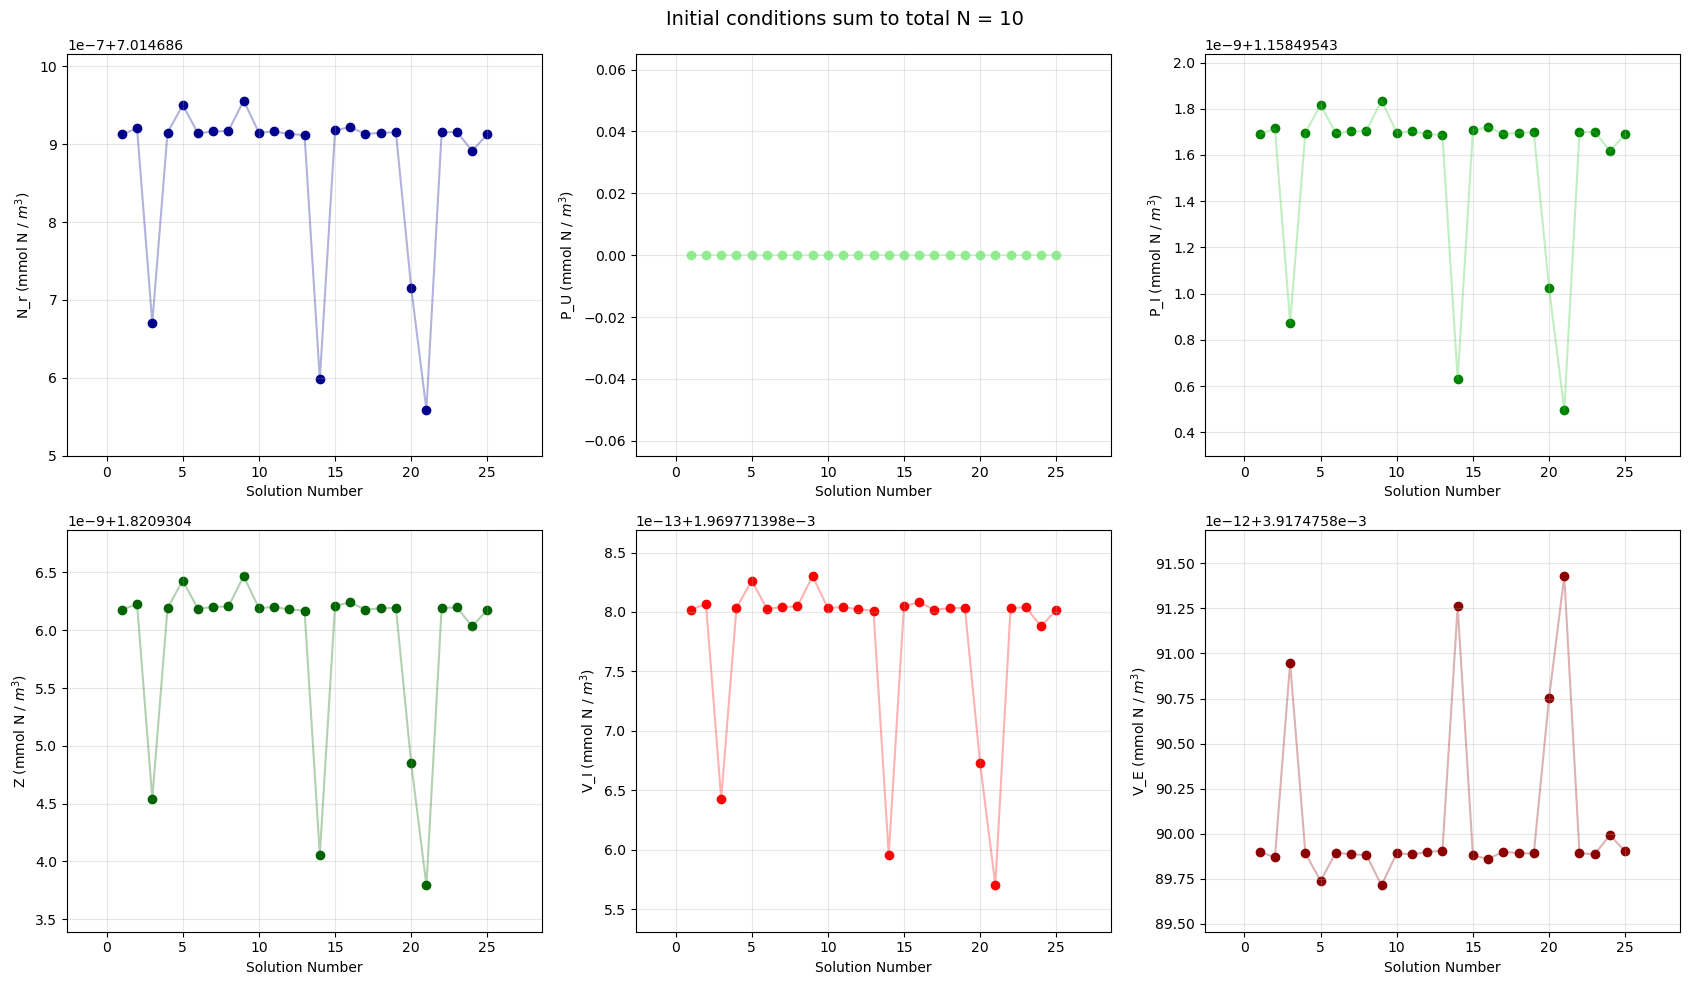

In [27]:
#Plot steady state solutions

%matplotlib inline

fig, axs = plt.subplots(2, 3, figsize=(17, 10))
plt.suptitle(f"Initial conditions sum to total N = {total_N}", fontsize=14)

x = np.arange(1, num_sim + 1)
 
axs[0][0].plot(x, N_r, color="darkblue", alpha=.3)
axs[0][0].scatter(x, N_r, color="darkblue")
axs[0][0].set_ylabel(r'N_r (mmol N / $m^3$)')

# for i, init in enumerate(init_cond):
#     axs[0][0].annotate(round(init[1], 2), (x[i], N_r[i]))
    
axs[0][1].plot(x, P_U, color="lightgreen", alpha=.3)
axs[0][1].scatter(x, P_U, color="lightgreen")
axs[0][1].set_ylabel(r'P_U (mmol N / $m^3$)')

# for i, init in enumerate(init_cond):
#     axs[0][1].annotate(round(init[2], 2), (x[i], P_U[i]))
    
axs[0][2].plot(x, P_I, color="limegreen", alpha=.3)
axs[0][2].scatter(x, P_I, color="green")
axs[0][2].set_ylabel(r'P_I (mmol N / $m^3$)')

# for i, init in enumerate(init_cond):
#     axs[0][2].annotate(round(init[3], 2), (x[i], P_I[i]))
    
axs[1][0].plot(x, Z, color="darkgreen", alpha=.3)
axs[1][0].scatter(x, Z, color="darkgreen")
axs[1][0].set_ylabel(r'Z (mmol N / $m^3$)')

# for i, init in enumerate(init_cond):
#     axs[1][0].annotate(round(init[4], 2), (x[i], Z[i]))
    
axs[1][1].plot(x, V_I, color="red", alpha=.3)
axs[1][1].scatter(x, V_I, color="red")
axs[1][1].set_ylabel(r'V_I (mmol N / $m^3$)')

# for i, init in enumerate(init_cond):
#     axs[1][1].annotate(round(init[5], 2), (x[i], V_I[i]))
    
axs[1][2].plot(x, V_E, color="darkred", alpha=.3)
axs[1][2].scatter(x, V_E, color="darkred")
axs[1][2].set_ylabel(r'V_E (mmol N / $m^3$)')

# for i, init in enumerate(init_cond):
#     axs[1][2].annotate(round(init[6], 2), (x[i], V_E[i]))
    
for ax in axs:
    for i in range(3):
        ax[i].ticklabel_format(style='sci')
        ax[i].set_xlabel(r"Solution Number")
        ax[i].margins(.15)
        ax[i].grid(alpha=.3)
        
    
plt.tight_layout()